In [1]:
import matplotlib.pyplot as plt
import numpy    as np
import torch    as tc
import qutip    as qt
import pandas   as pd
import torch.nn as nn
import random


from tqdm import tqdm
########################################### FUNCTION for run de algorithm ##################################################  

def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [XX,XY,XZ, YX,YY,YZ,ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect



O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]

In [2]:
from pathlib import Path

SEED            = 42
N               = 1000
tfinal          = 2*np.pi
std             = 0.02

np.random.seed(SEED)
tc.manual_seed(SEED)
random.seed(SEED)

index_data  = np.random.randint(0, N, size=50)

time        = tc.linspace(
                0,
                tfinal,
                N,
                dtype=tc.float32,
                requires_grad=True).reshape((-1, 1))
# Carregar parâmetros do arquivo CSV

csv_path = f"/home/gubio/CODESPACE/Pinn-inverse-for-opem-quantum-system/No fields/raw_data/parametro_nofields_N50_seed{SEED}_std{std}.csv"
df              = pd.read_csv(csv_path)
valor_real      = df['treino'].str.strip('[]').astype(float)
valor_previsto  = df['previsto'].str.strip('[]').astype(float)

# cores e marcadores (na mesma ordem das 4 séries)
colo   = ['c', 'r', 'g', 'b']   # ciano, vermelho, verde, azul (como na figura)
markes = ['^', 'x', 'o', '*']   # triângulo, xis, círculo, estrela

Computer the MSE from prediction exprectation value and de parameter values 

In [3]:
print("MSE: ", np.mean((valor_previsto.to_numpy() - valor_real.to_numpy())**2))
print("MAE: ", np.mean(abs(valor_previsto.to_numpy() - valor_real.to_numpy())))
print("MAPE: ", np.mean(abs(valor_previsto.to_numpy() - valor_real.to_numpy())/abs(valor_real.to_numpy())))

MSE:  3.989779961695093e-05
MAE:  0.005049189735790032
MAPE:  0.02649471073896662


In [4]:
######################### With parameter from PINNverse   ##################################################
Js          = valor_previsto[4:].to_numpy()
dissipation = valor_previsto[:4].to_numpy()  

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)

######################### With real parameter    ##################################################

Js          = valor_real[4:].to_numpy()
dissipation = valor_real[:4].to_numpy()  

valor_real_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
random_data = tc.normal(mean=0.0, std=std, size=valor_real_data.shape)
valor_esperado_data_noisy = valor_real_data + random_data  

/home/gubio/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Erro entre a curva experimental e teorica 

In [5]:
print( "MSE",np.mean((valor_esperado_data.numpy() - valor_esperado_data_noisy.numpy())**2))

MSE 0.00041904524552330784


Juntando os plotees

In [6]:
tc.linspace(
                0,
                tfinal,
                6,
                dtype   = tc.float32,
                requires_grad = True)/(2*np.pi)

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
       grad_fn=<DivBackward0>)

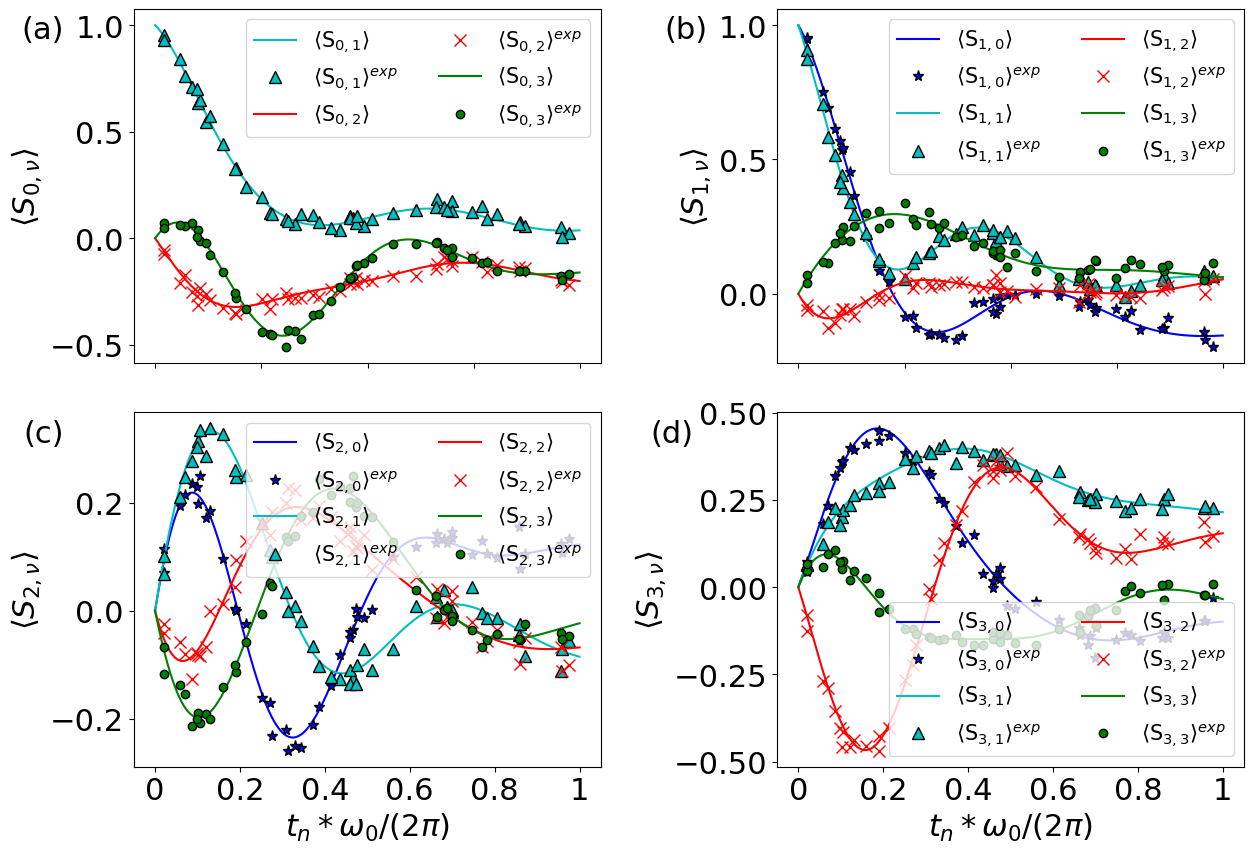

In [7]:
# Configuração geral
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(2, 2, figsize=(13, 9))
ax1, ax2, ax3, ax4 = axs.flatten()
xticks_labels = ['0','0.2', '0.4', '0.6', '0.8', '1']

# Subplot 1 (top-left)
for idx, i in enumerate(range(3)):
    ax1.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{0,{idx+1}}}$⟩")
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {"linestyle": "", "color": color, "marker": marker, "label": f"⟨S$_{{0,{idx+1}}}$⟩$^{{exp}}$"}
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8
    ax1.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax1.text(-0.15, .9, "(a)", transform=ax1.transAxes, va="bottom", ha="right")
ax1.set_ylabel(r'$\langle S_{0,\nu} \rangle$')
ax1.set_xticklabels([])         # sem rótulos na parte superior
ax1.legend(fontsize=15, loc='best', frameon=True, ncol=2, framealpha=0.8)

# Subplot 2 (top-right)
for idx, i in enumerate(range(3, 7)):
    ax2.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{1,{idx}}}$⟩")
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {"linestyle": "", "color": color, "marker": marker, "label": f"⟨S$_{{1,{idx}}}$⟩$^{{exp}}$"}
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8
    ax2.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax2.text(-0.15, .9, "(b)", transform=ax2.transAxes, va="bottom", ha="right")
ax2.set_ylabel(r'$\langle S_{1,\nu} \rangle$')
ax2.set_xticklabels([])         # sem rótulos na parte superior
ax2.legend(fontsize=15, loc='best', frameon=True, ncol=2, framealpha=0.8)

# Subplot 3 (bottom-left)
for idx, i in enumerate(range(7, 11)):
    ax3.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{2,{idx}}}$⟩")
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {"linestyle": "", "color": color, "marker": marker, "label": f"⟨S$_{{2,{idx}}}$⟩$^{{exp}}$"}
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8
    ax3.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)
ax3.set_xlabel(r"$t_n*\omega_0/ (2\pi)$")
ax3.text(-0.15, .9, "(c)", transform=ax3.transAxes, va="bottom", ha="right")
ax3.set_ylabel(r'$\langle S_{2,\nu} \rangle$')
ax3.set_xticks(np.linspace(0, N-1, len(xticks_labels)))
ax3.set_xticklabels(xticks_labels)
ax3.legend(fontsize=15, loc='best', frameon=True, ncol=2, framealpha=0.8)

# Subplot 4 (bottom-right)
for idx, i in enumerate(range(11, 15)):
    ax4.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{3,{idx}}}$⟩")
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {"linestyle": "", "color": color, "marker": marker, "label": f"⟨S$_{{3,{idx}}}$⟩$^{{exp}}$"}
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8
    ax4.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax4.text(-0.18, .9, "(d)", transform=ax4.transAxes, va="bottom", ha="right")
ax4.set_ylabel(r'$\langle S_{3,\nu} \rangle$')
ax4.set_xlabel(r"$t_n *\omega_0/ (2\pi)$")
ax4.set_xticks(np.linspace(0, N-1, len(xticks_labels)))
ax4.set_xticklabels(xticks_labels)
ax4.legend(fontsize=15, loc='best', frameon=True, ncol=2, framealpha=0.8)

# Ajustes finais
plt.tight_layout()
plt.savefig("Predic_withfields_subplots_2x2.png", dpi=500, bbox_inches='tight')
plt.show()
# ...existing code...

/tmp/ipykernel_15218/606138048.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


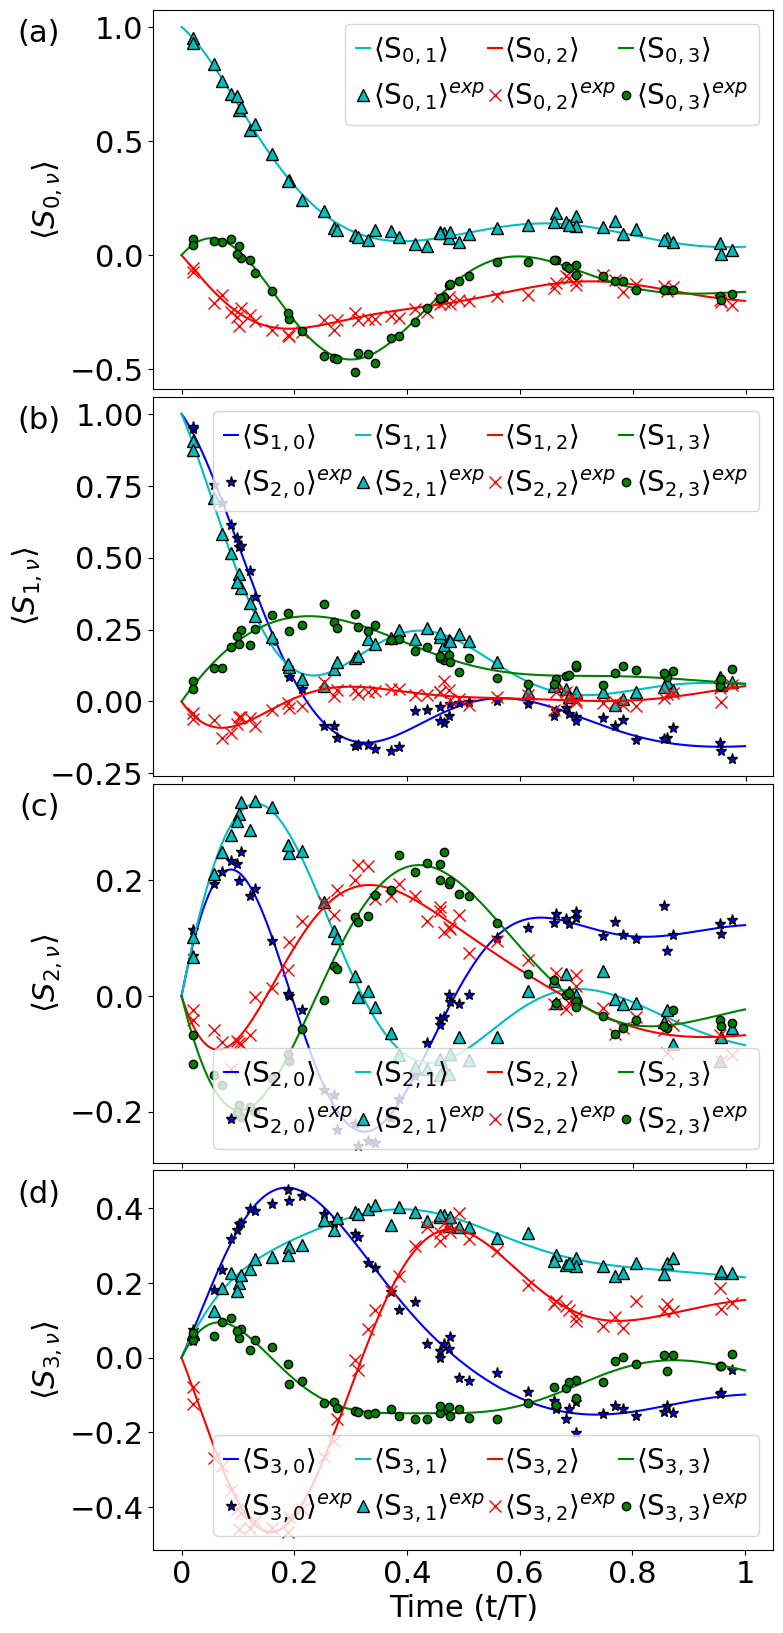

In [8]:
# Configuração geral
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(4, 1, figsize=(8, 20),gridspec_kw={'hspace': 0.02})  # Dois subplots lado a lado
ax1, ax2,ax3,ax4 = axs
xticks_labels = ['0','0.2', '0.4', '0.6', '0.8', '1']
# ==========================
# Subplot 1
# ==========================

for idx, i in enumerate(range(3)):
    ax1.plot(valor_esperado_data[:, i].cpu(), "-", 
             color=colo[i % len(colo)], label=f"⟨S$_{{0,{idx+1}}}$⟩")
    # Dados ruidosos
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{0,{idx+1}}}$⟩$^{{exp}}$"
    }
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8

    ax1.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

# marcador (a)
ax1.text(-0.15, .9, "(a)", transform=ax1.transAxes, va="bottom", ha="right")
ax1.set_ylabel(r'$\langle S_{0,\nu} \rangle$')
ax1.set_xticklabels("")
ax1.legend(fontsize=20, loc='best', frameon=True, ncol=3, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=.5)

# ============2=============
# Subplot 2
# ==========================

for idx, i in enumerate(range(3, 7)):
    ax2.plot(valor_esperado_data[:, i].cpu(), "-", 
             color=colo[i % len(colo)], label=f"⟨S$_{{1,{idx}}}$⟩")
    # Dados ruidosos
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{2,{idx}}}$⟩$^{{exp}}$"
    }
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8

    ax2.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax2.set_ylabel(r'$\langle S_{1,\nu} \rangle$')
ax2.set_xticklabels("")
ax2.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=0.5)

# marcador (b)
ax2.text(-0.15, .9, "(b)", transform=ax2.transAxes, va="bottom", ha="right")


# ============2=============
# Subplot 3
# ==========================

for idx, i in enumerate(range(7, 11)):
    ax3.plot(valor_esperado_data[:, i].cpu(), "-", 
             color=colo[i % len(colo)], label=f"⟨S$_{{2,{idx}}}$⟩")
    # Dados ruidosos
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{2,{idx}}}$⟩$^{{exp}}$"
    }
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8

    ax3.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax3.set_ylabel(r'$\langle S_{2,\nu} \rangle$')
ax3.set_xticklabels("")
ax3.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=0.5)

# marcador (c)
ax3.text(-0.15, .9, "(c)", transform=ax3.transAxes, va="bottom", ha="right")

# ==========================
# Subplot 4
# ==========================

for idx, i in enumerate(range(11, 15)):
    ax4.plot(valor_esperado_data[:, i].cpu(), "-", 
             color=colo[i % len(colo)], label=f"⟨S$_{{3,{idx}}}$⟩")
    # Dados ruidosos
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{3,{idx}}}$⟩$^{{exp}}$"
    }
    if marker != "x" and color != "r":
        plot_kwargs["markeredgecolor"] = "k"
    plot_kwargs["markersize"] = 6 if marker == "o" else 8

    ax4.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

ax4.set_ylabel(r'$\langle S_{3,\nu} \rangle$')
ax4.set_xlabel("Time (t/T)")
ax4.set_xticks(np.linspace(0, N-1, len(xticks_labels)))
ax4.set_xticklabels(xticks_labels)
ax4.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=.5)
# marcador (d)
ax4.text(-0.15, .9, "(d)", transform=ax4.transAxes, va="bottom", ha="right")

# ==========================
# Ajustes finais
# ==========================
plt.tight_layout()
plt.savefig("Predic_withfields_subplots.png", dpi=500, bbox_inches='tight')
plt.show()
